In [4]:
import numpy as np
from disentanglement_error.disentangling_model import DisentanglingModel
from disentanglement_error.error_metric import calculate_disentanglement_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras_uncertainty.models import TwoHeadStochasticRegressor
from keras_uncertainty.layers import StochasticDropout
from keras import backend as K


def custom_regression_gaussian_nll_loss(y_true, mean, variance):
    epsilon = 1e-8

    return 0.5 * K.mean(K.log(variance + epsilon) + K.square(y_true - mean) / (variance + epsilon))


class RegressionModel(DisentanglingModel):

    def __init__(self):
        super().__init__()

    def fit(self, X, y):
        inp = Input(shape=9)
        x = Dense(32, activation='relu')(inp)
        x = StochasticDropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        x = StochasticDropout(0.2)(x)
        x = Dense(16, activation='relu')(x)
        x = StochasticDropout(0.2)(x)
        mean = Dense(1, activation="linear")(x)
        var = Dense(1, activation="softplus")(x)
        label_layer = Input((1,))

        train_model = Model([inp, label_layer], [mean, var], name="train_model")
        pred_model = Model(inp, [mean, var], name="pred_model")

        loss = custom_regression_gaussian_nll_loss(label_layer, mean, var)
        train_model.add_loss(loss)

        train_model.compile(optimizer="adam", metrics=["mse"])
        train_model.fit([X, y], np.empty_like(y), epochs=75, batch_size=16, callbacks=EarlyStopping(monitor='loss', patience=5), verbose=0)
        final_model = TwoHeadStochasticRegressor(pred_model, variance_type="linear_std")

        self.model = final_model



    def predict_disentangling(self, x_test):
        pred_mean, pred_ale_std, pred_epi_std  = self.model.predict(x_test, num_samples=25, batch_size=32, disentangle_uncertainty=True)

        return pred_mean, pred_ale_std, pred_epi_std


    def score(self, y_true, y_pred):
        return 1 - mean_absolute_error(y_true, y_pred)

    def is_regression(self):
        return True

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

normalizer = StandardScaler()
normalizer.fit(train_features)
train_features = normalizer.transform(train_features)
test_features = normalizer.transform(test_features)

x_train = np.array(train_features).astype('float32')
y_train = np.array(train_labels).astype('float32')
x_test = np.array(test_features).astype('float32')
y_test = np.array(test_labels).astype('float32')


kw_config = {"n_runs": 3,

             }


de, result_json, config_json = calculate_disentanglement_error(x_train, y_train, RegressionModel(), x_test, y_test, kw_config=kw_config)
print(de)

0.6077874255635307


Experiment
Decreasing Dataset    Axes(0.125,0.11;0.775x0.77)
Label Noise           Axes(0.125,0.11;0.775x0.77)
dtype: object

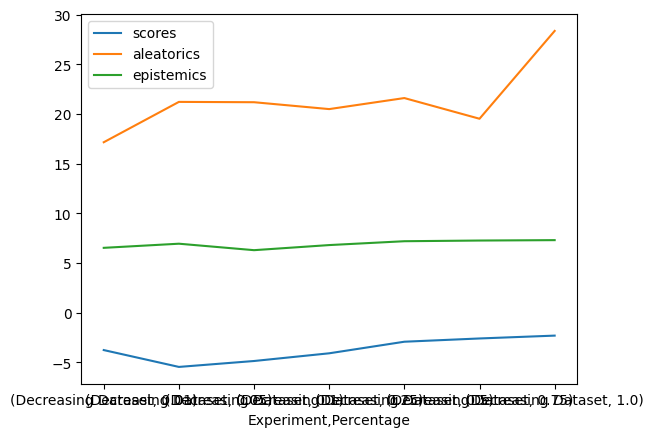

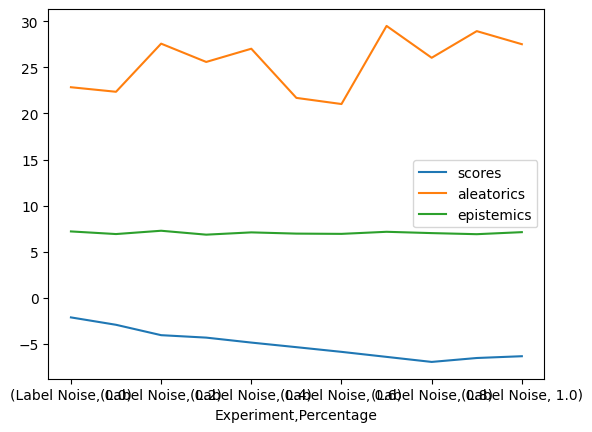

In [7]:
from disentanglement_error.util import json_results_to_df
df = json_results_to_df(result_json, config_json)
df.drop("Run_Index", axis=1).groupby(["Experiment", "Percentage"]).mean().groupby(['Experiment']).plot()